# Hello PyTorch Convolutional Neural Networks

This notebook introduces the notion of Convolution in images and provides a **hello world** example for convoluational neural networks.



In [6]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time as t
import cv2
import xarray as xr

device = "cuda" if torch.cuda.is_available() else "cpu"

## Image filters
### Sobel
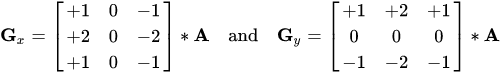


(171, 173)


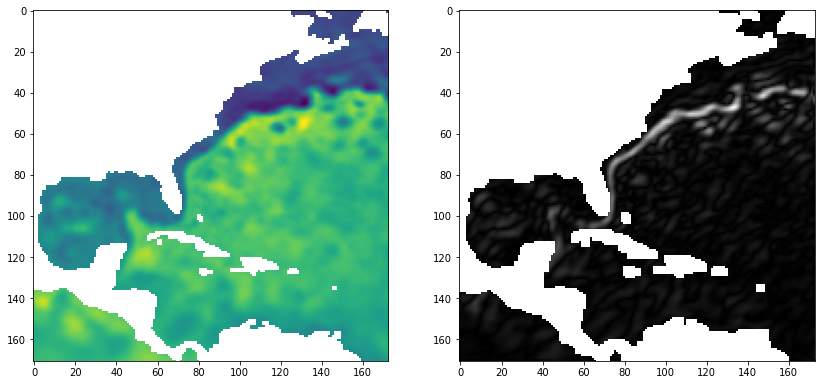

In [7]:
# Read example
aviso = xr.open_dataset('./imgs/1993-01.nc')
ssh = aviso['adt'].data[0,::-1,:]

# Define sobel kernels
sob_filter_y = np.array([[1,0,-1],
                       [2,0,-2],
                       [1,0,-1]])
sob_filter_x = np.array([[1,2,1],
                         [0,0,0],
                         [-1,-2,-1]])

# Compute convolution for each kernel
sobel_x = cv2.filter2D(src=ssh, ddepth=-1, kernel=sob_filter_x)
sobel_y = cv2.filter2D(src=ssh, ddepth=-1, kernel=sob_filter_y)

# Plot
fig, axs = plt.subplots(1,2, figsize=(14,7))
print(ssh.shape)
axs[0].imshow(ssh)
axs[1].imshow(np.abs(sobel_x + sobel_y), cmap='gray')

1. Generate some synthetic data

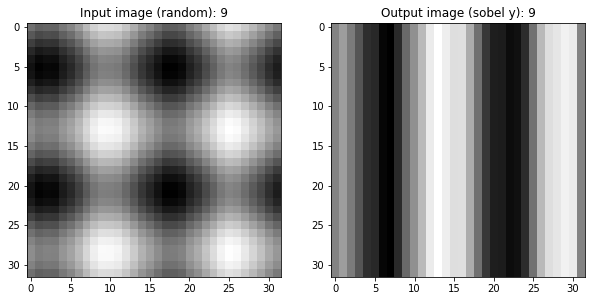

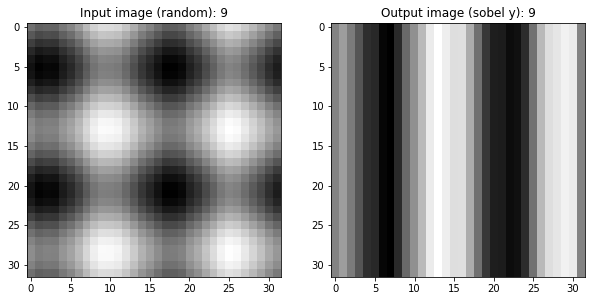

In [10]:
# Create some synthetic data
## Create syntethic data
examples = 10000 # Total amount of examples
grid_size = 32
data = np.zeros((examples, grid_size, grid_size))
x = np.linspace(0, 4*np.pi, grid_size)
xx, yy = np.meshgrid(x,x)

X = np.array([np.sin(xx+np.random.rand(1)*grid_size) + np.sin(yy+np.random.rand(1)*grid_size) + .2*np.random.rand(grid_size) for i in range(examples)])
Y = np.array([cv2.filter2D(src=x, ddepth=-1, kernel=sob_filter_y) for x in X])
# Y = np.array([np.abs(cv2.filter2D(src=x, ddepth=-1, kernel=sob_filter_y) + cv2.filter2D(src=x, ddepth=-1, kernel=sob_filter_x)) for x in X])
print(Y.shape)

fig, axs = plt.subplots(1,2, figsize=(10,5))
for i in range(10):
    axs[0].cla()
    axs[1].cla()
    display.clear_output(wait =True)
    axs[0].imshow(X[i,:,:], cmap='gray')
    axs[0].set_title(f'Input image (random): {i}')
    axs[1].imshow(Y[i,:,:],cmap='gray')
    axs[1].set_title(f'Output image (sobel y): {i}')
    plt.draw()
    t.sleep(0.1)
    display.display(plt.gcf())
display.clear_output(wait =True)

Single CNN layer model
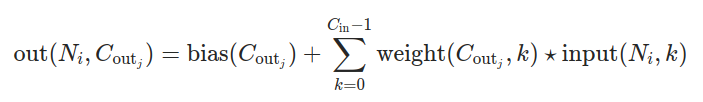


[('conv1.weight', Parameter containing:
tensor([[[[-0.0274, -0.0261,  0.0931],
          [ 0.0686,  0.2761,  0.1867],
          [-0.2792, -0.1892, -0.2616]]]], device='cuda:0', requires_grad=True)), ('conv1.bias', Parameter containing:
tensor([0.0892], device='cuda:0', requires_grad=True))]
Original shape (10000, 32, 32)
Input shape torch.Size([10000, 1, 32, 32])


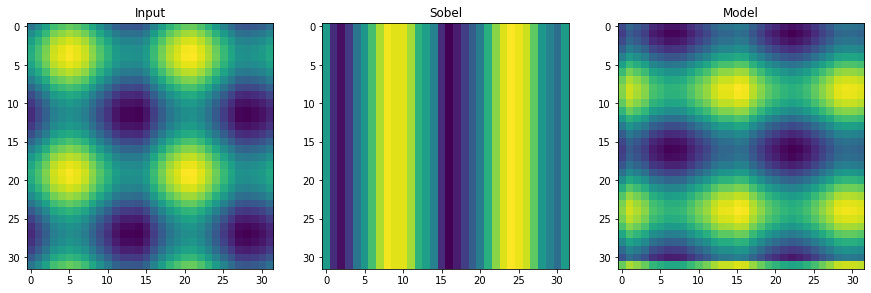

In [11]:
# Models are created by classes that inherit from Module
class SingleCNNModel(nn.Module):
    # On the init function we define our model
    def __init__(self):
        super().__init__() # Constructor of parent class
        self.conv1 =  nn.Conv2d(1, 1, 3, padding=1, padding_mode='reflect')
        self.relu = nn.ReLU()
        # self.conv2 =  nn.Conv2d(1, 1, 1)
        # self.bn = nn.BatchNorm2d(1)
    
    # On the forward function we indicate how to make one 'pass' of the model
    def forward(self, x):
        l1 = self.conv1(x)
        # # ---------
        # for i in range(5):
        #     l1 = self.bn(self.relu(self.conv1(l1)))
        # l1 = self.conv2(l1)
        # ----------
        return l1

    
ex_model = SingleCNNModel().to(device)
print(list(ex_model.named_parameters()))

# Reshape to the proper input of the network
X_torch = torch.reshape(torch.tensor(X), (X.shape[0], 1, X.shape[1], X.shape[2])).to(device, dtype=torch.float)
Y_torch = torch.reshape(torch.tensor(Y), (Y.shape[0], 1, Y.shape[1], Y.shape[2])).to(device, dtype=torch.float)
print("Original shape", X.shape)
print("Input shape", X_torch.shape)

model_y = ex_model(X_torch).cpu().detach().numpy()
#-------------- Just for plotting --------------
fig, ax = plt.subplots(1,3, figsize=(15,5))
def plotCurrentModel(x, y, model, ax):
    # Torch receives inputs with shape [Examples, input_size]
    ax[0].imshow(x)
    ax[0].set_title('Input')
    ax[1].imshow(y)
    ax[1].set_title('Sobel')
    im = ax[2].imshow(model)
    ax[2].set_title('Model')
    
ex = 0
plotCurrentModel(X[ex,:,:], Y[ex,:,:], model_y[ex,0,:,:], ax)

3.Optimize the parameters of the model using backpropagation 

In [12]:
loss_mse = nn.MSELoss() # Define loss function
optimizer = torch.optim.SGD(ex_model.parameters(), lr=8e-3) # Define optimization algorithm

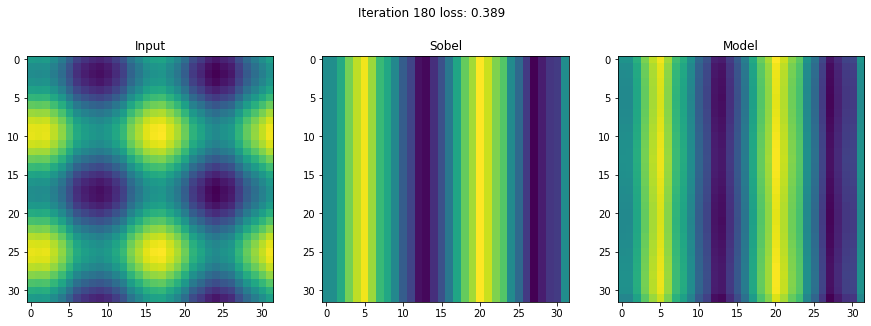

Done!
[('conv1.weight', Parameter containing:
tensor([[[[ 0.9428, -0.1050, -1.0332],
          [ 1.1244,  0.2828, -0.8540],
          [ 0.8846, -0.0745, -1.1944]]]], device='cuda:0', requires_grad=True)), ('conv1.bias', Parameter containing:
tensor([0.0070], device='cuda:0', requires_grad=True))]


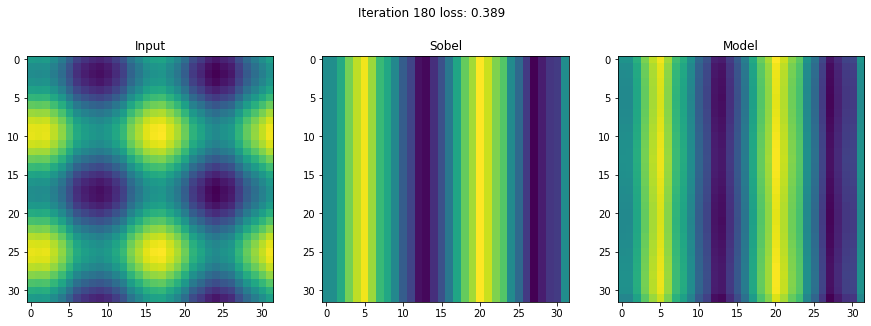

In [13]:
# Optimize the parameters several times

fig, ax = plt.subplots(1,3, figsize=(15,5))
ex_model.train()
for i in range(200):
    pred = ex_model(X_torch)
    loss = loss_mse(pred, Y_torch)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # ---------- Just for plotting ---------
    if i % 20 == 0: 
        title = f"Iteration number {i} loss: {loss:0.3f}"
        display.clear_output(wait =True)
        ex = np.random.randint(0,1000,1)[0]
        model_y = ex_model(X_torch).cpu().detach().numpy()
        plotCurrentModel(X[ex,:,:], Y[ex,:,:], model_y[ex,0,:,:], ax)
        plt.suptitle(f'Iteration {i} loss: {loss:.3f}')
        plt.draw()
        t.sleep(0.1)
        display.display(plt.gcf())
    
print("Done!")
print(list(ex_model.named_parameters()))
display.clear_output(wait =True)